In [1]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import scipy

In [2]:
# load data
data_raw = pd.read_csv("primary_results.csv")
print(data_raw)
print(data_raw.shape)
# null counts
print(data_raw.isna().sum())

         state state_abbreviation          county        fips       party  \
0      Alabama                 AL         Autauga      1001.0    Democrat   
1      Alabama                 AL         Autauga      1001.0    Democrat   
2      Alabama                 AL         Baldwin      1003.0    Democrat   
3      Alabama                 AL         Baldwin      1003.0    Democrat   
4      Alabama                 AL         Barbour      1005.0    Democrat   
...        ...                ...             ...         ...         ...   
24606  Wyoming                 WY  Teton-Sublette  95600028.0  Republican   
24607  Wyoming                 WY   Uinta-Lincoln  95600027.0  Republican   
24608  Wyoming                 WY   Uinta-Lincoln  95600027.0  Republican   
24609  Wyoming                 WY   Uinta-Lincoln  95600027.0  Republican   
24610  Wyoming                 WY   Uinta-Lincoln  95600027.0  Republican   

             candidate  votes  fraction_votes  
0       Bernie Sanders    5

1. Carge este archivo en un dataframe. Descríbalo (columnas, número de observaciones, valores nulos) ¿Qué filas/columnas le sirven para el problema?

El archivo tiene 24611 observaciones y 8 variables, todos los valores nulos corresponden a fips.
El problema considerara como variable dependiente "candidate", las restantes columnas seran usadas como predictores, excepto "fips" que es la variable id.
Sin embargo podemos eliminar las variables state-state_abbreviation en tanto aportan la misma informacion y
la variable party en tanto aporta informacion directa del candidato, dependiendo de como se considere el problema.
En tanto estas son votaciones de una primaria podriamos determinar (1) los resultados de las votaciones por 'party' of bien considerar al ganador simplemente como quien recibio la mayor cantidad de votos.
Para este trabajo considerare la votacion como si fuese una votacion libre (no tipo primaria), por lo tanto se observaran los votos netos obtenidos.

2. Cree una variable binaria que indique si en dicho county Trump tuvo o no la mayoría de los votos. Esa será su variable dependiente para la clasificación. Explore el balance de dicha variable.

                state state_abbreviation        county        fips  \
18027  South Carolina                 SC     Lexington     45063.0   
12501        Michigan                 MI       Sanilac     26151.0   
7413         Kentucky                 KY       Garrard     21079.0   
1100         Arkansas                 AR       Garland      5051.0   
14291        Nebraska                 NE        Garden     31069.0   
...               ...                ...           ...         ...   
1894      Connecticut                 CT      Hartford  90900064.0   
22870        Virginia                 VA  Harrisonburg     51660.0   
19312           Texas                 TX        Harris     48201.0   
8501            Maine                 ME    Harrington  92300195.0   
18246    South Dakota                 SD       Ziebach     46137.0   

            party        candidate   votes  fraction_votes  trump_dummy  \
18027  Republican     Donald Trump   16361           0.300            1   
12501  Re

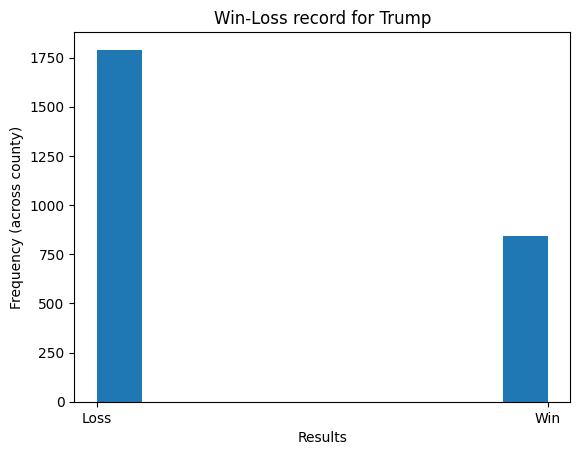

In [3]:
data_proc = data_raw

# esto no considera que esta sea una votacion tipo primaria
# por lo tanto busca el indice por county que tuvo la mayor cantidad de votos netos
idx = data_raw.groupby('county')['votes'].idxmax()

# seleccionar esas filas y cortar el max
# simplemente interesa la fila que corresponde al candidato con mas votas netos
data_proc = data_raw.loc[idx]

# crear la dummy
data_proc['trump_dummy'] = np.where(data_proc['candidate'] == 'Donald Trump', 1, 0)
data_proc['trump_dummy_cat'] = np.where(data_proc['trump_dummy'] == 1, "Win", "Loss")
print(data_proc.sort_values(by = 'trump_dummy', ascending=False))

# proporcion de victorias y derrotas de trump
prop_of_trump = round(data_proc['trump_dummy'].mean(), 2)
print(f"Proporcion de victorias: {prop_of_trump}")
print(f"Proporcion de derrotas: {round(1 - prop_of_trump, 2)}")

# representacion grafica
plt.hist(data_proc['trump_dummy_cat'])
plt.xlabel("Results")
plt.ylabel("Frequency (across county)")
plt.title("Win-Loss record for Trump")
plt.show()

3. Ahora necesitamos un conjunto de regresores. Para ello cargue el archivo 'county_facts.csv'. Explore dicho dataframe. Recuerde que tiene a disposición el libro de códigos.

In [4]:
predictors_raw = pd.read_csv("county_facts.csv")
print(predictors_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fips                3195 non-null   int64  
 1   area_name           3195 non-null   object 
 2   state_abbreviation  3143 non-null   object 
 3   PST045214           3195 non-null   int64  
 4   PST040210           3195 non-null   int64  
 5   PST120214           3195 non-null   float64
 6   POP010210           3195 non-null   int64  
 7   AGE135214           3195 non-null   float64
 8   AGE295214           3195 non-null   float64
 9   AGE775214           3195 non-null   float64
 10  SEX255214           3195 non-null   float64
 11  RHI125214           3195 non-null   float64
 12  RHI225214           3195 non-null   float64
 13  RHI325214           3195 non-null   float64
 14  RHI425214           3195 non-null   float64
 15  RHI525214           3195 non-null   float64
 16  RHI625


4. Revisando el libro de códigos, vamos a seleccionar un subconjunto de columnas:

'AGE775214' : Persons 65 years and over, percent, 2014
'RHI725214' : Hispanic or Latino, percent, 2014
'EDU685213' : Bachelor's degree or higher, percent of persons age 25+, 2009-2013
'HSG445213' : Homeownership rate, 2009-2013
'PVY020213' : Persons below poverty level, percent, 2009-2013
'SBO015207' : Women-owned firms, percent, 2007
'BZA010213' : Private nonfarm establishments, 2013
'LND110210' : Land area in square miles, 2010

Siéntase libre de escoger otro conjunto de columnas. Esto es solo para no demorarnos tanto.

Describa las variables de interés. ¿Hay valores nulos? ¿Hay outliers? Para esto último puede visualizar histogramas o usar la función describe() para ver la estadística descriptiva.

          MAN450207     WTN220207     RTN130207     AFN120207     PST045214  \
count  3.195000e+03  3.195000e+03  3.195000e+03  3.195000e+03  3.195000e+03   
mean   4.732329e+06  3.804132e+06  3.677504e+06  5.739886e+05  2.993963e+05   
std    9.623516e+07  7.613666e+07  7.082882e+07  1.112830e+07  5.768468e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  7.818500e+04  6.240000e+03  1.113450e+04   
50%    7.103000e+04  4.852600e+04  2.604220e+05  2.606300e+04  2.655300e+04   
75%    9.766630e+05  2.677625e+05  8.358655e+05  1.037800e+05  7.247600e+04   
max    5.319456e+09  4.174287e+09  3.917663e+09  6.137957e+08  3.188571e+08   

          PST040210     POP010210     HSG010214     BZA110213     HSD410213  \
count  3.195000e+03  3.195000e+03  3.195000e+03  3.195000e+03  3.195000e+03   
mean   2.899137e+05  2.899019e+05  1.257814e+05  1.100748e+05  1.085542e+05   
std    5.584181e+06  5.583955e+06  2.418522e+06  2.

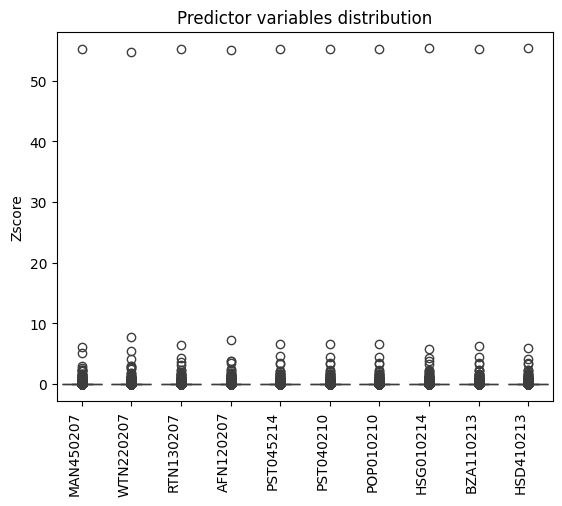

      MAN450207  WTN220207  RTN130207  AFN120207  PST045214  PST040210  \
0          True       True       True       True       True       True   
1          True       True       True       True       True       True   
2         False      False      False      False      False      False   
3         False      False       True       True       True       True   
4         False      False      False      False      False      False   
...         ...        ...        ...        ...        ...        ...   
3190      False      False      False      False      False      False   
3191      False      False      False       True      False      False   
3192      False      False      False      False      False      False   
3193      False      False      False      False      False      False   
3194      False      False      False      False      False      False   

      POP010210  HSG010214  BZA110213  HSD410213  
0          True       True       True       True  
1        

In [5]:
# para determinar las variables usare como metrica
# la desviacion estandar, generare un ranking
# y tomare arbitrariamente las 10 primeras variables
# filtrare variables no numericas y el id
features_to_rank = predictors_raw.drop(columns=['fips']).select_dtypes(include='number')
std_devs = features_to_rank.std()
rank = std_devs.rank(ascending=False)
rank_col = pd.DataFrame({
    'std': std_devs,
    'rank': rank
}).sort_values(by='rank')
# seleccionar el top 10
final_features = rank_col.head(10)
predictors_proc = predictors_raw[final_features.index.tolist() + ['fips']]
# distribucion
print(predictors_proc.describe())
# valores nulos
print(predictors_proc.isna().sum())

# representacion grafica para distribucion/outliers
# generamos zscores para que sean comparables
tmp = predictors_proc.drop(columns='fips')
zscores = tmp.apply(scipy.stats.zscore)
predictors_zscore = zscores

sns.boxplot(data = predictors_zscore)
plt.xticks(rotation=90, ha='right')
plt.title("Predictor variables distribution")
plt.ylabel("Zscore")
plt.show()

# el grafico indica que variables relacionadas con ventas y crecimiento poblacional
# cuentan con valores por encima de las 50 desviaciones estandar del promedio
# valores muy por encima de 3 std probablemente no hacen sentido
# usare una estrategia conservadora para eliminarlos en base a
# el rango intercuartilico, cambiando el pivot de media a mediana para 
# no ser influenciado por los valores extremos
Q1 = tmp.quantile(0.25)
Q3 = tmp.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (tmp < lower_bound) | (tmp > upper_bound)
print(outliers)

# construir la base de features final
predictors_final = tmp[~outliers.any(axis=1)].join(predictors_proc[['fips']])
print(predictors_final)


5. Vemos que para algunas variables tenemos outliers. Vamos a eliminar cualquier instancia mayor que 5

. Esto puede no ser la solución más ideal, sobretodo porque hay muchos algoritmos que son sensibles a los outliers. Para esto usamos la función zscore(). También podemos escalar la data con RobustScaler()

(modifique esto en base a las variable seleccionadas y el metodo de outliers fue usando IQR, luego de observacion via zscores)

6. Finalmente, haga un merge entre ambas bases de datos para tener todo lo necesario para entrenar los clasificadores.

In [6]:
data_merged = pd.merge(data_proc, predictors_final, on='fips')
print(data_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               1160 non-null   object 
 1   state_abbreviation  1160 non-null   object 
 2   county              1160 non-null   object 
 3   fips                1160 non-null   float64
 4   party               1160 non-null   object 
 5   candidate           1160 non-null   object 
 6   votes               1160 non-null   int64  
 7   fraction_votes      1160 non-null   float64
 8   trump_dummy         1160 non-null   int32  
 9   trump_dummy_cat     1160 non-null   object 
 10  MAN450207           1160 non-null   int64  
 11  WTN220207           1160 non-null   int64  
 12  RTN130207           1160 non-null   int64  
 13  AFN120207           1160 non-null   int64  
 14  PST045214           1160 non-null   int64  
 15  PST040210           1160 non-null   int64  
 16  POP010

7. Especificar un random forest.
Para encontrar un RF con el numero optimo de arboles, es necesario especificar el resto de hiper-parameteros, de otra manera, podemos encontrar el numero optimo de arboles en cuanto encontramos la especificacion optima de todo los hiper-parametros.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from scipy.stats import randint, uniform
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

Fitting 2 folds for each of 100 candidates, totalling 200 fits
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 80, 'max_features': 0.9411525976057388, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 198}


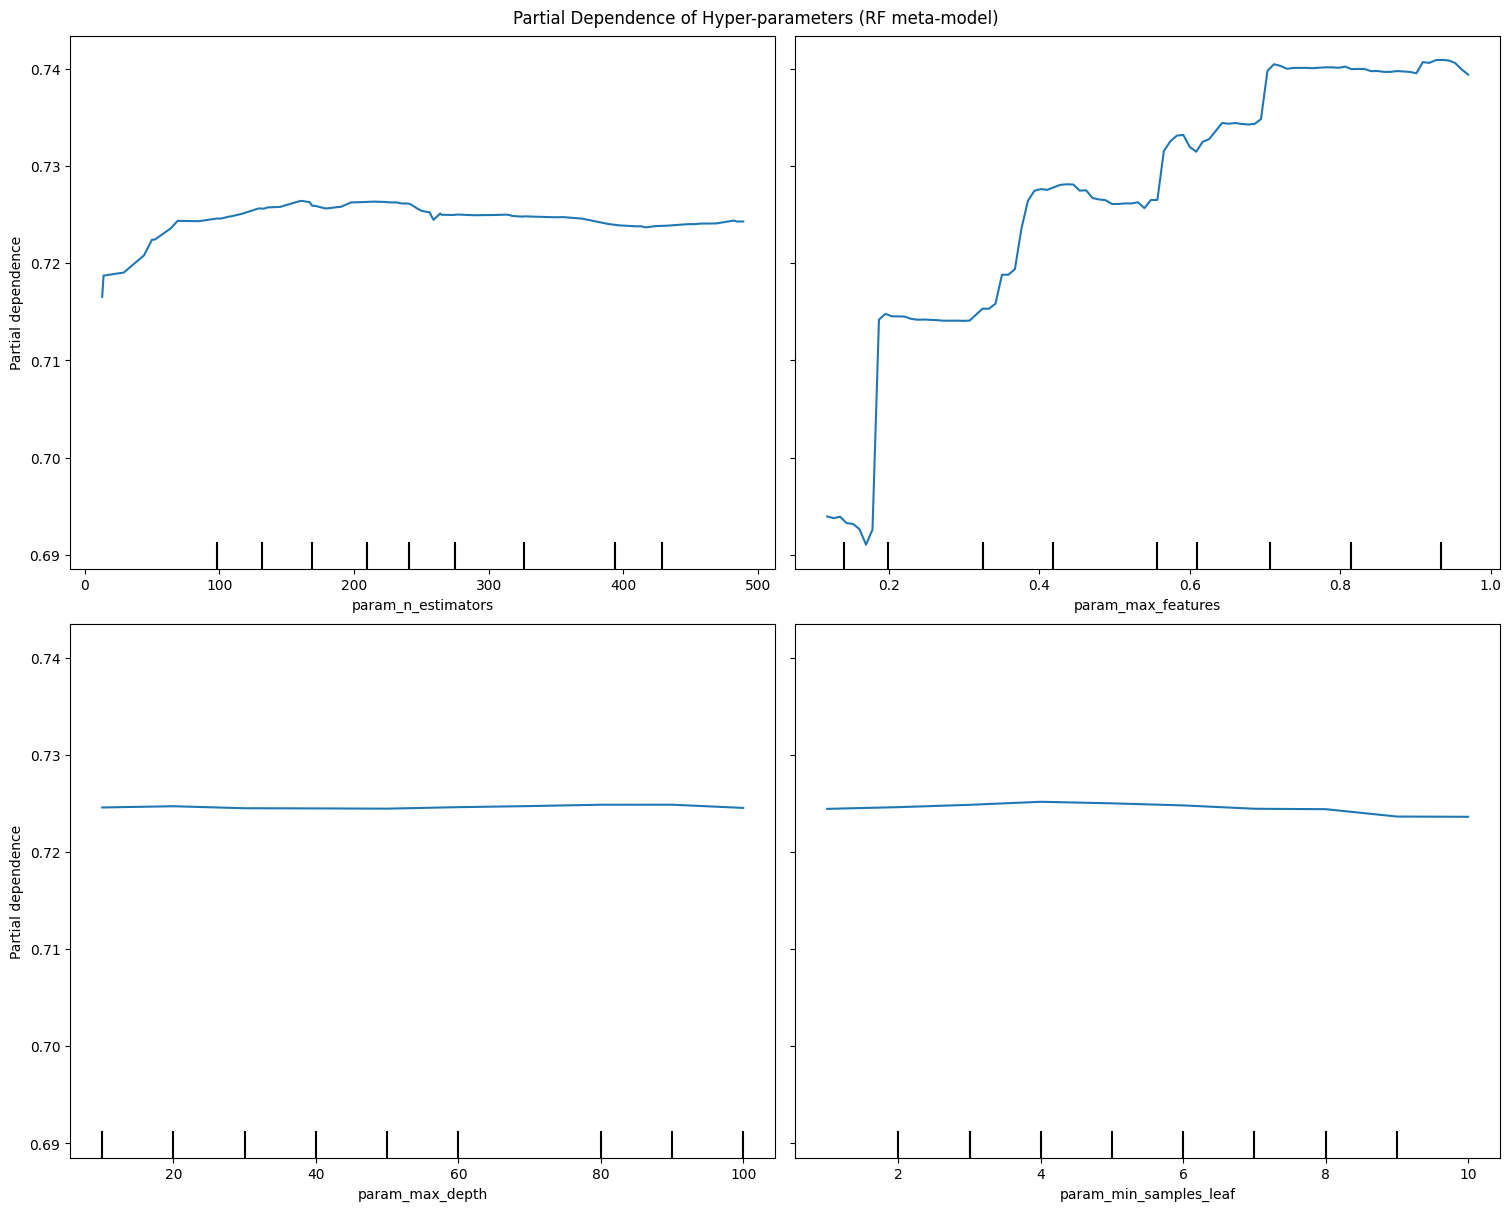

In [8]:
# el primer paso es optimizar los hyper-parametros del RF
# la estrategia para hacerlo mas rapido es hacer uso 
# de la computacion interna del algoritmo de un error out-of-bag (aqui computaremos el oob accuracy score, para mantener los mejores valores en positivo)
# y probar una grilla aleatoria de paramateros, aunque lo ideal seria 
# una busqueda en grillas uniformes of algun algoritmo de busqueda como los de evolucion

# funcion para extraer el OOB accuracy score
def oob_scorer(estimator, X, y):
    return estimator.oob_score_

# ordenar variables dependendiente e independientes
# remuevo county, ya que en este dataset se puede considerar
# como un indice y llevar a overfitting
X = data_merged.drop(columns=['trump_dummy', 'trump_dummy_cat',
                             'state_abbreviation', 'party', 'fips',
                             'fraction_votes', 'votes', 'candidate', 'county'])
X['state'] = pd.factorize(X['state'])[0]
y = data_merged['trump_dummy_cat']

param_dist = {
    # parametro a observar, numero de arboles
    'n_estimators': randint(10, 500),
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf': randint(1, 11),
    'min_samples_split': randint(2, 21),
    'max_features': uniform(0.1, 0.9),
    'bootstrap': [True],
    'criterion': ['gini']
}

# iniciar el clasificador
# n_jobs=-1 es para usar todos los cpu!
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    # pocas iteracion para prueba de concepto
    n_iter=100,
    # sklearn require almenos 1 particion, tecnicamente esto no es necesario
    # pero computacionalmente no es problematico, en tanto tomamos el OOB the ambas
    # y se obtiene un promedio simple, ganando un poco mas de estabilidad en el
    # estimado final
    cv=2,
    scoring=oob_scorer,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)
best_params = random_search.best_params_
print(best_params)

# pora la representacion grafica construire un grafico de dependencia parcial
# asi poder determinar la calidad del modelo en base al numero de arboles
# mientras se considera el resto de hiper-parametros
optim_results = pd.DataFrame(random_search.cv_results_)
mm_features = [
    'param_n_estimators',
    'param_max_features',
    'param_max_depth',
    'param_min_samples_leaf'
]
X_mm = optim_results[mm_features]
y_mm = optim_results['mean_test_score']

# fit del metamodelo
meta_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    oob_score=True
)
meta_model.fit(X_mm, y_mm)

# representacion grafica
fig, ax = plt.subplots(
    2, 2, figsize=(15,12), constrained_layout=True
)
fig.suptitle('Partial Dependence of Hyper-parameters (RF meta-model)')
display = PartialDependenceDisplay.from_estimator(
    meta_model,
    X_mm,
    features=mm_features,
    ax=ax
)
plt.show()

La funcion de dependencia parcial (el eje y es su output), estima el efecto marginal de una 'feature' $S$ en la prediccion de un modelo $f$, computado de la siguiente forma:
$$\hat{f}_S(x_S) = \frac{1}{n} \sum_{i=1}^{n} f(x_S, x_{C,i})$$
Donde:
- $\hat{f}_S(x_S)$ es la funcion de dependencia parcial para la 'feature' $S$ evaluado en el valor $x_S$
- $n$ es el numero de instancias en el dataset
- $x_S$ es el valor espefico de la 'feature' de interes
- $x_{C,i}$ representa los valores de todas las otras 'features' para la $i-esima$ instancia en el dataset

Idealmente, se buscaria obtener algun 'bootstrap' de las metricas presentadas para determinar el nivel de incertidumbre. Sin embargo, y considerando una unica corrida del meta-modelo. Se observa que cercano a los ~100-200 arboles (param_n_estimators), se obtiene un 'codo', luego del cual el rendimiento es considerablemente estable. En terminos teoricos el punto optimo del arbol es referente a la demanda computacional, en tanto una mayor cantidad de arbol solo deberia tener el efecto de hacer menos variable la prediccion, sin afectar el sesgo. Por lo tanto ~100-200 arboles parece ser el minimo necesario para que el modelo sea computacionalmente estable.

Para determinar el desempeno del modelo utilizamos los parametros optimizados y con ellos corremos una 'cross-validation' para obtener la metrica de accuracy promedio.

In [9]:
# en base a estos parametros especificamos el modelo
print(best_params)
optimal_model = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

# asumimos una especie de jerarquia donde las observaciones
# pertenencen a un 'state' particular
cv_strat = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)
scoring_metrics = ['accuracy']

# correr la crossvalidation
cv_results = cross_validate(
    optimal_model,
    X, y,
    cv=cv_strat,
    scoring=scoring_metrics
)

# rendimiento obtenido
mean_score = round(cv_results['test_accuracy'].mean(), 2)
std_score = round(cv_results['test_accuracy'].std(), 2)
print(f"Mean accuracy: {mean_score}, std: {std_score}")

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 80, 'max_features': 0.9411525976057388, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 198}
Mean accuracy: 0.76, std: 0.04


8. Especificar un MLP, optimizar hiper-parametros y reportar resultados.

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'mlp__activation': 'relu', 'mlp__alpha': 0.07090725777960455, 'mlp__hidden_layer_sizes': (150, 100), 'mlp__learning_rate_init': 0.006641157902710026, 'mlp__solver': 'sgd'}


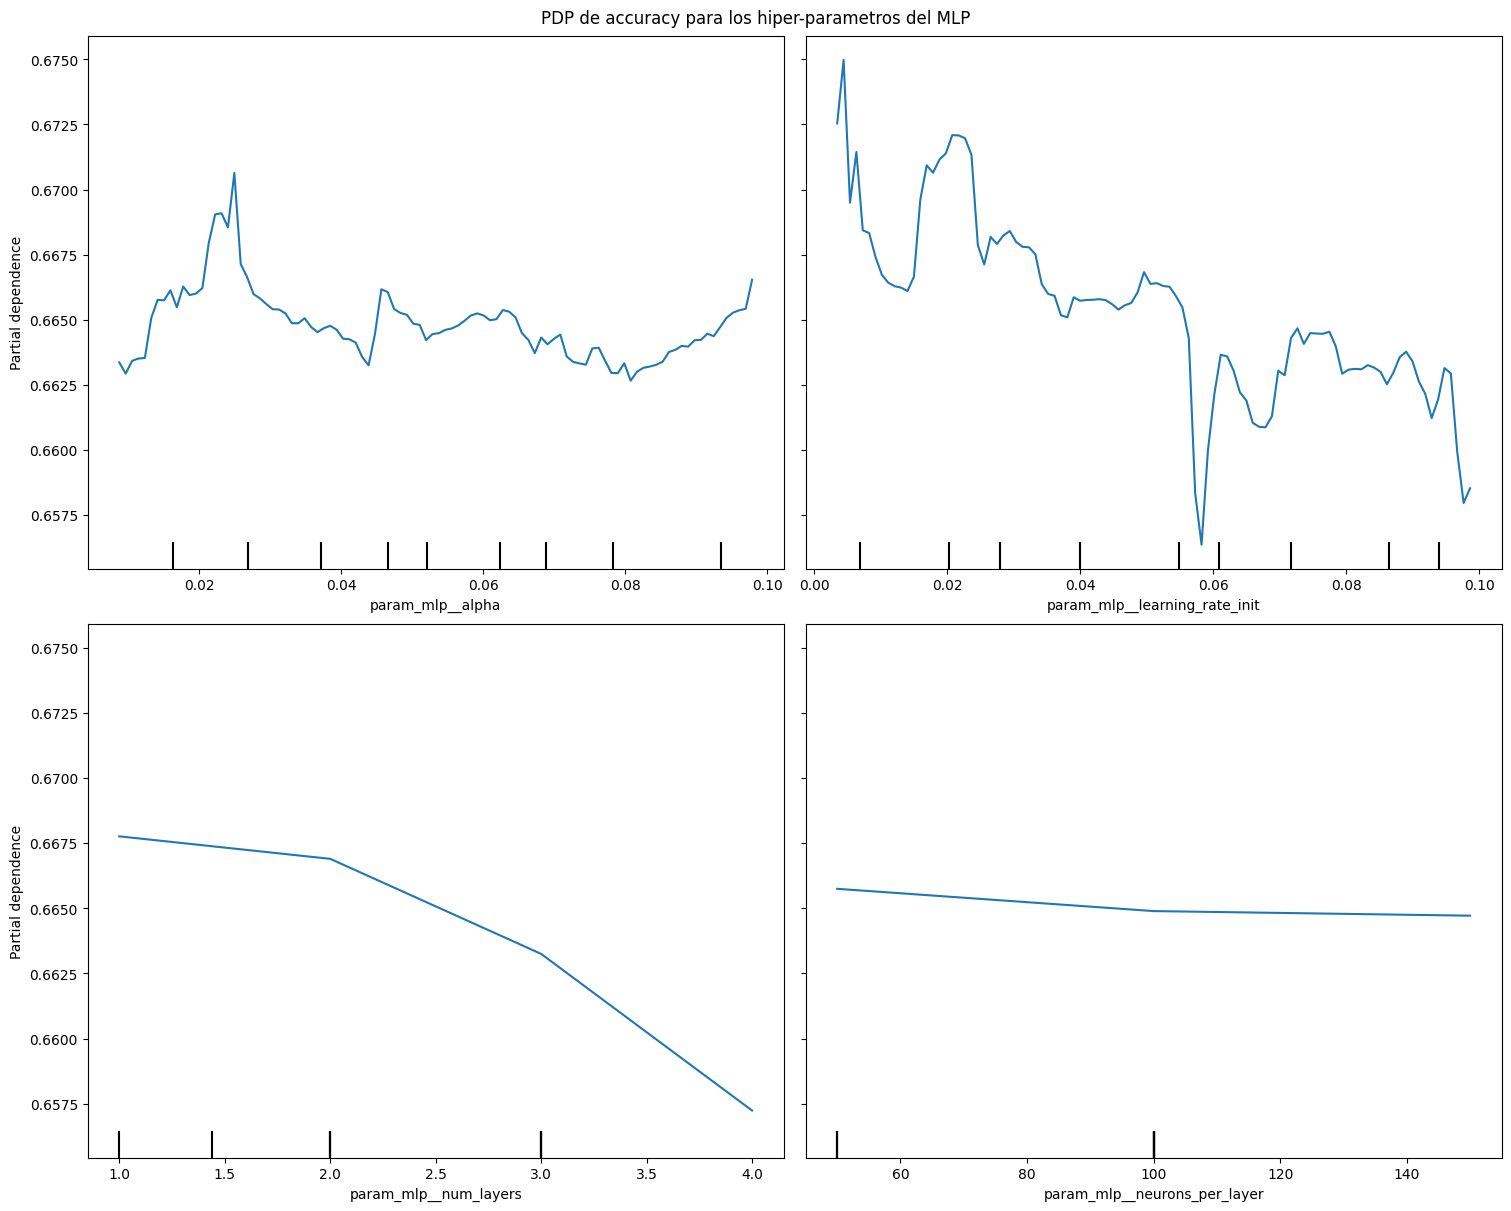

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# establecer el pipeline de optimizacion
param_dist = {
    'mlp__hidden_layer_sizes': [
        # 1 layer
        (50,), (100,),
        # 2 layer
        (50, 50), (100, 50),
        # 3 layer
        (100, 100), (150, 100),
        # 4 layer
        (50, 50, 50), (100, 100, 50), (100, 100, 100),
        # 5 layer
        (50, 50, 50, 50)],
    # fijando los parametros categoricos
    # para observar los parametros mas cuantitativos
    'mlp__activation': ['relu'],
    'mlp__solver': ['sgd'],
    'mlp__alpha': uniform(0.0001, 0.1),
    'mlp__learning_rate_init': uniform(0.001, 0.1)
}

pipeline = Pipeline([
    ('scales', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

# busqueda aleatoria de la grilla
random_search_mlp = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    verbose=3,
    random_state=42,
    n_jobs=-1
)

random_search_mlp.fit(X, y)
results_df_mlp = pd.DataFrame(random_search_mlp.cv_results_)
# best params
print(random_search_mlp.best_params_)

# data para el metamodelo
results_df_processed_mlp = results_df_mlp.copy()
results_df_processed_mlp['param_mlp__num_layers'] = results_df_processed_mlp['param_mlp__hidden_layer_sizes'].apply(lambda x: len(x))
results_df_processed_mlp['param_mlp__neurons_per_layer'] = results_df_processed_mlp['param_mlp__hidden_layer_sizes'].apply(lambda x: x[0])
results_df_processed_mlp = pd.get_dummies(results_df_processed_mlp, columns=['param_mlp__activation', 'param_mlp__solver'])

# entrenar el metamodelo para general los partial-dependence-plots
features_for_pdp = [
    'param_mlp__alpha',
    'param_mlp__learning_rate_init',
    'param_mlp__num_layers',
    'param_mlp__neurons_per_layer'
]
X_mm_mlp = results_df_processed_mlp[features_for_pdp]
y_mm_mlp = results_df_processed_mlp['mean_test_score']

meta_model_mlp = RandomForestRegressor(n_estimators=100, random_state=42)
meta_model_mlp.fit(X_mm_mlp, y_mm_mlp)

# representacion grafica
fig, ax = plt.subplots(
    2, 2,
    figsize=(15, 12),
    constrained_layout=True
)
fig.suptitle('PDP de accuracy para los hiper-parametros del MLP')
display = PartialDependenceDisplay.from_estimator(
    meta_model_mlp,
    X_mm_mlp,
    features=features_for_pdp,
    ax=ax)

plt.show()

Los parametros optimos del MLP quedan descritos en 'random_search_mlp.best_params_'. En terminos generales los PDPs nos indican que una arquitectura relativamente simple y poco profunda parece ser la optima, favoreciendo tasas de aprendizaje mas bajas ('param_mlp__learning_rate_init') y regularizacion mas suave ('param_mlp_alpha'). Para el numero de capas ('param_mlp__num_layers') muestra mejores resultados en rangos bajos, probablemente indicando que la funcion subyacente en los datos no es de gran complejidad, en el numero de neuronas se ve algo similar pero menos pronunciado, probablemente relacionado con la baja dimensionalidad (al seleccionar el top 10 de variables por desviacion standard). Abajo se encuentran anotados los valores de accuracy para el modelo optimizado.

In [12]:
mean_cv_accuracy_mlp = random_search.best_score_
best_model_index = random_search.best_index_
std_cv_accuracy_mlp = random_search.cv_results_['std_test_score'][best_model_index]


print(f"Hiper-parametros optimos: {random_search.best_params_}\n")
print(f"Accuracy promedio en crossvalidation: {mean_cv_accuracy_mlp}")
print(f"Desviacion estandar de la accuracy: {std_cv_accuracy_mlp}")

Hiper-parametros optimos: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 80, 'max_features': 0.9411525976057388, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 198}

Accuracy promedio en crossvalidation: 0.7482758620689656
Desviacion estandar de la accuracy: 0.006896551724137889
